In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import gc
!nvidia-smi

Mon Sep 12 23:51:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.77       Driver Version: 512.77       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   45C    P8     9W / 184W |   1041MiB / 12288MiB |     22%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 設定訓練及測試資料集和訓練參數

In [2]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [3]:
BIT_COUNT = 16
iterations = 7  #攻擊次數
alpha = 0.0001  #攻擊程度
epsilon = 8.0 / 255  #攻擊範圍
EPOCH = 50 #訓練EPOCH

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = x_train[:1500]
y_train = y_train[:1500]
x_test = x_test[:1500]

x_train = rgb2gray(x_train)
x_train = np.expand_dims(x_train, axis=-1)
x_test = rgb2gray(x_test)
x_test = np.expand_dims(x_test, axis=-1)



x_train = tf.image.resize(x_train, [28,28]).numpy()
x_test = tf.image.resize(x_test, [28,28]).numpy()

image_shape = (28, 28, 1)
x_train = x_train.reshape((-1,) + image_shape)
x_test = x_test.reshape((-1,) + image_shape)

## 設定資料擴增

In [4]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

data_augmentation = tf.keras.Sequential([
    RandomRotation(0.02, fill_mode = 'constant'),
    RandomZoom(.2, .2)
])

## 設定訓練模型

In [5]:
adam = Adam(learning_rate=0.0002, beta_1=0.5)

In [6]:
inputs = Input((28, 28, 1))
x = Conv2D(64, (3, 3), padding="same", activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding="same", activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, (3, 3), padding="same", activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(BIT_COUNT+1, activation="softmax")(x)
decoder = Model(inputs=inputs, outputs=x)
decoder.compile(optimizer=adam, loss='binary_crossentropy', metrics=['categorical_accuracy'])
decoder.summary()
from keras.utils.vis_utils import plot_model
plot_model(decoder, to_file='model.png', show_shapes=True,show_layer_names=False)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4624  

In [7]:

#利用pgd的idea修改圖片 讓它生出我想要的label
def pgd_attack_to_target(input_image, target_label, loss_object, model, epsilon, alpha, iterations):
    x_adv = input_image  # 複製一個圖片 (不要動到原圖片)
    for i in range(iterations):  # 做很多次
        x_adv = tf.convert_to_tensor(x_adv)  # 將圖片轉成tensor
        with tf.GradientTape() as tape:  #開始計算梯度
            tape.watch(x_adv)  # 要計算的圖片是x_adv
            prediction = model(x_adv)  #先做判斷(取得目前的結果)
            loss = loss_object(target_label, prediction)  # 計算loss(距離target有多遠)
        grad = tape.gradient(loss, x_adv)  # 計算梯度 (loss對x_adv的梯度，d_loss/d_x_adv)
        x_adv_new  = x_adv - alpha * tf.sign(grad)  # 更新圖片(做梯度下降會讓預測結果接近我想要的label)
        x_adv = tf.clip_by_value(x_adv_new , x_adv - epsilon, x_adv + epsilon)  # 限制圖片的範圍
        x_adv = tf.clip_by_value(x_adv, 0, 1)  # 限制圖片的範圍(圖片要在0~1之間)
        x_adv = x_adv.numpy()  # 將圖片轉成numpy
    return x_adv  # 回傳攻擊後的圖片

In [8]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    dec_loss = losses["decoder"]

    plt.figure(figsize=(10, 8))
    plt.plot(dec_loss, label="decoder loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [9]:
list = np.array([ i for i in range(BIT_COUNT+1)])
user_code = np.eye(BIT_COUNT+1)[list]
print(user_code)  #生成onehot encoding

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## 訓練模型

In [10]:

DATA_LENGTH = len(x_train)

# x_train_adv[0]是沒有攻擊的圖片
x_train_adv = [x_train.copy() for _ in range(BIT_COUNT+1)]

losses = {"decoder": []}

#開始訓練
for epoch in range(EPOCH):

    ##第一步 調整圖片 讓decoder能正確讀取出user_code
    for i in range(1, BIT_COUNT+1):
        x_train_adv[i] = pgd_attack_to_target(x_train_adv[i], [user_code[i]] * DATA_LENGTH,
                                              tf.keras.losses.CategoricalCrossentropy(), decoder, epsilon,
                                              alpha, iterations)

    ##第二步 data augmentation(旋轉，縮放....)
    x_train_adv_att = [data_augmentation(x_train_adv[i]) for i in range(BIT_COUNT+1)]

    #第四步 訓練Decoder
    decoder_x = np.concatenate((np.concatenate([x_train_adv[i] for i in range(BIT_COUNT+1)]),
                                np.concatenate([x_train_adv_att[i] for i in range(BIT_COUNT+1)])))
    decoder_y = np.concatenate((np.concatenate([[user_code[i]] * DATA_LENGTH for i in range(BIT_COUNT+1)]),
                                np.concatenate([[user_code[i]] * DATA_LENGTH for i in range(BIT_COUNT+1)])))

    decoder_loss = decoder.fit(decoder_x, decoder_y, epochs=1)

    #紀錄loss
    # losses["discriminator"].append(discriminator_loss.history["loss"])
    losses["decoder"].append(decoder_loss.history["loss"])
    print("epoch:{}  decoder_loss:{}".format(epoch, decoder_loss.history["loss"]))



1594/1594 [==============================] - 15s 9ms/step - loss: 0.2303 - categorical_accuracy: 0.0585
epoch:0  decoder_loss:[0.23027417063713074]
1594/1594 [==============================] - 14s 9ms/step - loss: 0.2244 - categorical_accuracy: 0.0582
epoch:1  decoder_loss:[0.2243887037038803]
1594/1594 [==============================] - 14s 9ms/step - loss: 0.2243 - categorical_accuracy: 0.0584
epoch:2  decoder_loss:[0.22425632178783417]
1594/1594 [==============================] - 14s 9ms/step - loss: 0.2242 - categorical_accuracy: 0.0601
epoch:3  decoder_loss:[0.2241986095905304]
1594/1594 [==============================] - 14s 9ms/step - loss: 0.2241 - categorical_accuracy: 0.0577
epoch:4  decoder_loss:[0.22412356734275818]
1594/1594 [==============================] - 14s 9ms/step - loss: 0.2240 - categorical_accuracy: 0.0619
epoch:5  decoder_loss:[0.2240455597639084]
1594/1594 [==============================] - 14s 9ms/step - loss: 0.2240 - categorical_accuracy: 0.0612
epoch:6  de

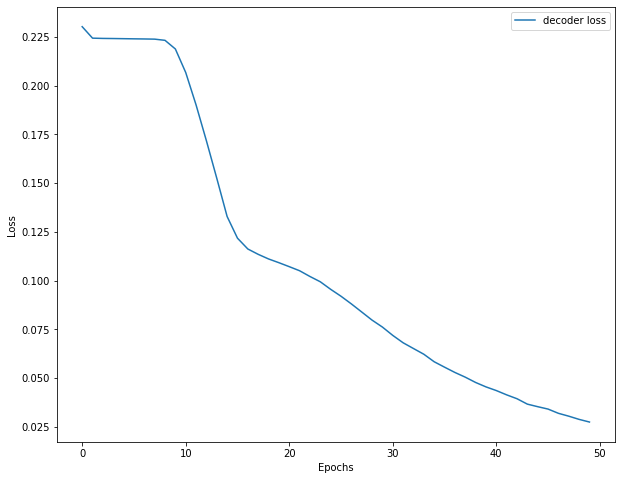

In [11]:
plot_loss(losses)

In [12]:
# decoder.save('models/decoder_one_hot_4_bit_cifar_10_binary_crossentropy.h5')

In [ ]:
plot_loss(losses)

In [ ]:
# decoder.save('models/decoder_one_hot_4_bit_cifar_10_binary_crossentropy.h5')